### Differential Equation

$\frac{\mathrm{d}\Psi_1}{\mathrm{d}x} = cos(x) + \Psi_1^2 + \Psi_2 - (1 + x^2 + sin^2(x)),$

$\frac{\mathrm{d}\Psi_2}{\mathrm{d}x} = 2x - (1 - x^2)sin(x) + \Psi_1\Psi_2,$

$\Psi_1(0) = 0, \Psi_2(0) = 1, x \in [0, 3]$

In [24]:
from typing import List, Callable
import autograd.numpy as np

from core.neural_network import init_weights, forward
from core.optimizers import gradient_descent, adam
from core.activation_functions import elu, sigmoid, tanh, arctan
from core.plotting_tools import plot_ode, plot_system_ode

In [25]:
PSI_0 = np.array([0, 1])


def derivative(x, psi) -> np.ndarray:
    """Example #4 derivative.
    Args:
        x: The input vector
        psi: The function vector

    Returns:
        Value of psi's partial derivatives at x.
    """
    psi_1_dot = np.cos(x) + psi[0] ** 2 + psi[1] - (1 + x**2 + np.sin(x) ** 2)
    psi_2_dot = 2 * x - (1 - x**2) * np.sin(x) + psi[0] * psi[1]
    return np.array([psi_1_dot, psi_2_dot])


def analytical_solution(x):
    """Analytical solution to example #4.
    Args:
        x: The input vector

    Returns:
        Value of psi at x.
    """
    psi_1 = np.sin(x)
    psi_2 = 1 + x**2

    return np.array([psi_1, psi_2])


def trial_solution(
    t: np.array, weights_list: List[List[np.array]], activation_fns: List[Callable]
) -> np.ndarray:
    """Calculates the trial solution of the system of DEs.

    Args:
        t: The input vector
        weights_list: A list of weights and biases for each neural networks

    Returns:
        A NumPy array of the trial solution of the system of DEs
        dimension (len(weights_list), len(t))
    """
    f = [
        forward(t, weights_list[i], activation_fns).reshape(t.size)
        for i in range(len(weights_list))
    ]
    return np.array([PSI_0[i] + t * f[i] for i in range(len(weights_list))])

### Training

In [26]:
def train():
    t = np.arange(0, 2, 0.05)
    hidden_sizes = np.array([10, 10, 10])
    activation_fns = [tanh] * (len(hidden_sizes)) + [lambda x: x]
    nn_weights_1 = init_weights(1, hidden_sizes, 1)
    nn_weights_2 = init_weights(1, hidden_sizes, 1)
    adam(
        t,
        [nn_weights_1, nn_weights_2],
        activation_fns,
        trial_solution,
        derivative,
        num_iters=150000,
        step_size=0.001,
        threshold=0.0001,
    )

    return [nn_weights_1, nn_weights_2], activation_fns


weights_list, activation_fns = train()

Iteration:  0
 14.858249057680348
Iteration:  1
 14.527210879202384
Iteration:  2
 14.208892283240704
Iteration:  3
 13.902964838214746
Iteration:  4
 13.608907749246624
Iteration:  5
 13.326036890874894
Iteration:  6
 13.0535557903538
Iteration:  7
 12.790661997974237
Iteration:  8
 12.536661826031255
Iteration:  9
 12.29097780243812
Iteration:  10
 12.053102035843018
Iteration:  11
 11.822559899220677
Iteration:  12
 11.598892479420337
Iteration:  13
 11.381650172755037
Iteration:  14
 11.170391509778907
Iteration:  15
 10.964684259430554
Iteration:  16
 10.764107512914709
Iteration:  17
 10.568254134754069
Iteration:  18
 10.376733237870242
Iteration:  19
 10.189172470324758
Iteration:  20
 10.00521996813178
Iteration:  21
 9.824545867489498
Iteration:  22
 9.646843320798588
Iteration:  23
 9.471829032556817
Iteration:  24
 9.299243404672804
Iteration:  25
 9.128850435363795
Iteration:  26
 8.960437532707129
Iteration:  27
 8.793815369837521
Iteration:  28
 8.628817838401055
Iterati

KeyboardInterrupt: 

### Evaluating Results

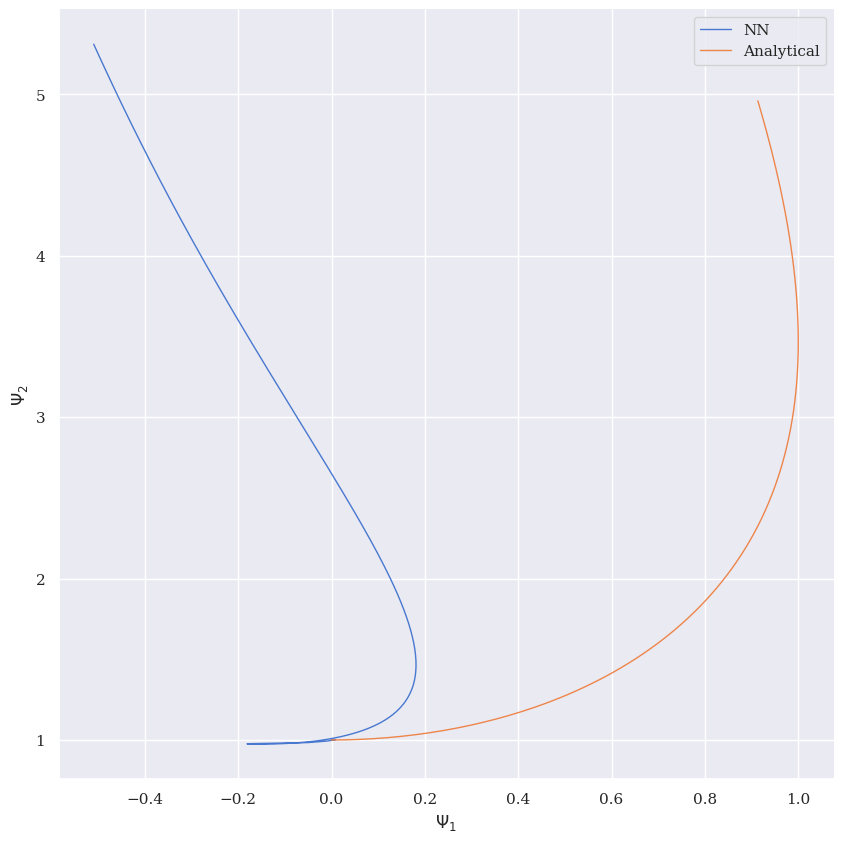

In [22]:
t = np.arange(0, 2, 0.01)
res = trial_solution(t, weights_list, activation_fns)
an_sol = analytical_solution(t)

plot_system_ode(res, an_sol)